# Multilinear Predictions of net calcification

This section outlines the methodology used to generate predictions of net reef calcification in response to forecasted temperature and pH parameters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
%matplotlib inline

In [2]:
ds = xr.open_dataset('future_data/feather_forecast.nc')


In [3]:
X_forecast = ds.to_dataframe()
X_forecast.rename(columns={'ph': 'PH'}, inplace=True)
X_forecast


,temp,PH
time,,
2019-04-01,25.931612,8.062175
2019-05-01,24.387908,8.075403
2019-06-01,23.531681,8.080693
2019-07-01,23.618569,8.077623
2019-08-01,24.547945,8.064382
...,...,...
2060-09-01,25.401802,7.999633
2060-10-01,26.752390,7.988518
2060-11-01,27.912811,7.977087


## 1. Plotting data just to quickly check that it is all there

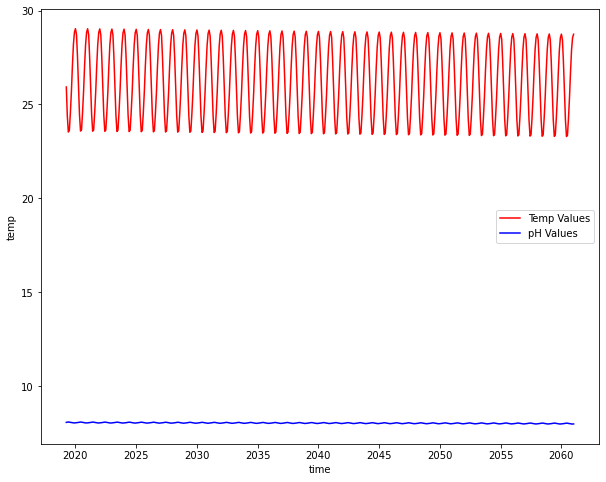

In [4]:
plt.figure(figsize=(10, 8))

ax = sns.lineplot(data= X_forecast,x = 'time', y= 'temp' , color="r", label="Temp Values")
sns.lineplot(data= X_forecast, x = 'time', y= 'PH', color="b", label="pH Values" , ax=ax)

plt.show()
plt.close()

## 2.Date Range

We have to create a date range of that predicted in the previous notebook to assign to the calcification prediction we're about to produce

In [5]:
date_rng = pd.date_range(start='2019-04-01', end='2061-01-01', freq='MS')


Opening the calcification related parameters collected in notebook 1.

In [6]:
data = xr.open_dataset('Reef-Data/Feather_reef.nc')
data = data.to_dataframe()
data

,temp,Gnet,PH
time,,,
2016-11-01,27.343014,0.023243,8.042113
2016-11-02,27.648985,0.023581,8.044712
2016-11-03,27.739407,0.023873,8.042665
2016-11-04,27.732176,0.023543,8.042204
2016-11-05,28.010515,0.022833,8.037282
...,...,...,...
2019-11-24,27.694706,0.024843,8.042093
2019-11-25,27.413813,0.024969,8.046000
2019-11-26,27.711020,0.025059,8.049218


# 3. Multivariate linear regression

In order to conduct a MLR we need need to split the dataset into our independent and dependent variables

In [7]:
X_var = data[['temp', 'PH']] # independent variables
y_var = data['Gnet'] # dependent variable


Here we used the statsmodels package to utilise regression models

In [8]:
import statsmodels.api as sm
import termcolor
from termcolor import colored as cl

sm_X_var = sm.add_constant(X_var)

mlr_model = sm.GLM(y_var, sm_X_var)
mlr_reg = mlr_model.fit()

In [9]:
print(cl(mlr_reg.summary(), attrs = ['bold']))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Gnet   No. Observations:                 1122
Model:                            GLM   Df Residuals:                     1119
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                      2.3622e-05
Method:                          IRLS   Log-Likelihood:                 4386.0
Date:                Fri, 05 Nov 2021   Deviance:                     0.026433
Time:                        09:48:56   Pearson chi2:                   0.0264
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1456      0.122      9.426      0.0

# 4.Training the model

Here we split the data set into training and testing. 

The testing is used to teach the model the impacts of temperature and pH on calcification 

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_var, y_var, test_size = 0.3, random_state = 0)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)


Here we can compare the outcomes of actual Gnet and model predicted Gnet

In [11]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

,Actual,Predicted
time,,
2018-12-17,0.024028,0.021837
2019-05-11,0.026453,0.020484
2017-12-01,0.024032,0.021280
2019-08-14,0.024584,0.023425
2018-03-27,0.024077,0.018714
...,...,...
2017-09-17,0.021496,0.026373
2018-10-13,0.023983,0.023592
2018-07-21,0.023917,0.022166


In [12]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(cl('R-Squared :', attrs = ['bold']), lr.score(X_test, y_test))

Mean Absolute Error: 0.0034700898
Mean Squared Error: 2.4154506e-05
Root Mean Squared Error: 0.0049147233
R-Squared : 0.04190218196379003


## 4.1. Plotting the outcomes

The next two plots show:
1. Timeseries match of predicted and actual variables 
2. Density plot of predicted variables and actual variables

The closer the lines the better the model

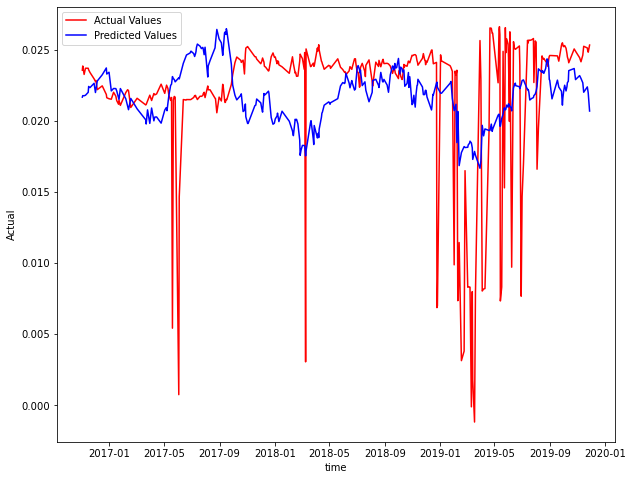

In [13]:
plt.figure(figsize=(10, 8))

ax = sns.lineplot(data= df,x = 'time', y= 'Actual' , color="r", label="Actual Values")
sns.lineplot(data= df, x = 'time', y= 'Predicted', color="b", label="Predicted Values" , ax=ax)

plt.show()
plt.close()


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


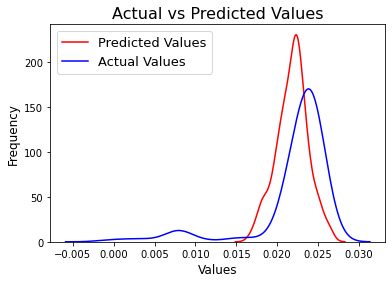

In [14]:

sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

# 5. Using foreccasts

Now we're going to use the forecaseted data from notebook 2 and the trained model to predict the calcification in response to temperature and pH

In [15]:
y_forecast = lr.predict(X_forecast)
Gnet_forecast = pd.DataFrame({'time':date_rng,'Predicted_Gnet':y_forecast})
Gnet_forecast.index = pd.to_datetime(Gnet_forecast['time'])
Gnet_forecast.drop(['time'], axis=1, inplace=True)
Gnet_forecast

,Predicted_Gnet
time,
2019-04-01,0.022911
2019-05-01,0.024386
2019-06-01,0.025512
2019-07-01,0.025778
2019-08-01,0.025683
...,...
2060-09-01,0.033494
2060-10-01,0.032135
2060-11-01,0.031249


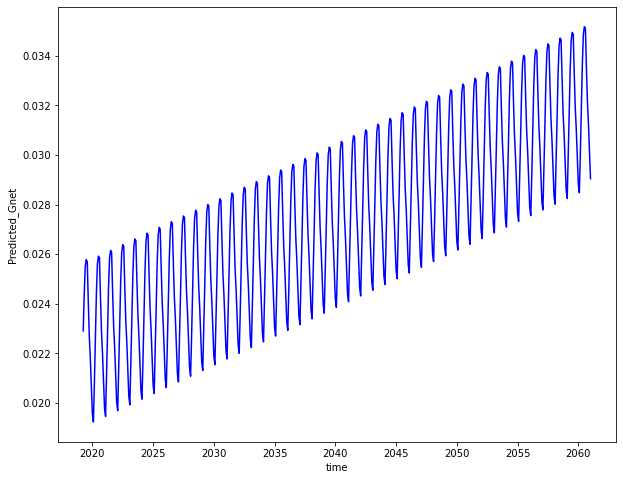

In [16]:
plt.figure(figsize=(10, 8))

sns.lineplot(data= Gnet_forecast, x='time', y='Predicted_Gnet', color="b")

plt.show()


Now that this data has been obtained we can begin to calculate individual reef calcification in response to predicted future changes.

Example below:

In [17]:
change = xr.Dataset(Gnet_forecast.to_xarray())

change = change.sel(time='2061-01-01').mean() - change.sel(time='2019-04-01').mean()

print(f'Change in net calcification: {round((((change.Predicted_Gnet.values)*86400)/1000),4)}(grams/m-2/day-1)')


Change in net calcification: 0.5298(grams/m-2/day-1)


## 6. A function for this process

In [18]:
def Gnet_pred(forecast,Gnet,fname):
    
    '''
    This function takes the data produced by the param_predict() and Gnet_data() functions to produce a forecast of net calcification to 2061
    
    args:
    
    - forecast: fname.nc data produced by the param_predict() function. Should contain forecasted values of temperature and pH
    - Gnet: fname.nc data produced by the Gnet_data() function. Should contain values of temperature, pH and Gnet obtained from AIMS eReefs data
    - fname: Name of saved projected gnet data
    '''
    
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import xarray as xr
    import seaborn as sns
    
    ds = xr.open_dataset(f'future_data/{forecast}.nc')
    X_forecast = ds.to_dataframe()
    X_forecast.rename(columns={'ph': 'PH'}, inplace=True)
    
    date_rng = pd.date_range(start='2019-04-01', end='2061-01-01', freq='MS')
    
    data = xr.open_dataset(f'Reef-Data/{Gnet}.nc')
    data = data.to_dataframe()
    
    X_var = data[['temp', 'PH']]
    y_var = data['Gnet'] # dependent variable
    
    
    import statsmodels.api as sm
    from termcolor import colored as cl

    sm_X_var = sm.add_constant(X_var)
    
    mlr_model = sm.GLM(y_var, sm_X_var)
    mlr_reg = mlr_model.fit()
    print(cl(mlr_reg.summary(), attrs = ['bold']))
    
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_var, y_var, test_size = 0.2, random_state = 0)

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_test)
    
    df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
    
    from sklearn import metrics
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R-Squared :', lr.score(X_test, y_test))
    
    y_forecast = lr.predict(X_forecast)
    gnet_forecast = pd.DataFrame({'time':date_rng,'Predicted_Gnet':y_forecast})
    gnet_forecast.index = pd.to_datetime(gnet_forecast['time'])
    gnet_forecast.drop(['time'], axis=1, inplace=True)
    
    change = xr.Dataset(gnet_forecast.to_xarray())

    change = change.sel(time='2061-01-01')-change.sel(time='2019-04-01')

    print(cl(f'Change in net calcification (2019-2061): {round((((change.Predicted_Gnet.values)*86400)/1000),4)}(grams/m-2/day-1)', attrs = ['bold']))
    fig, axes = plt.subplots(3,1,figsize=(15,15))

    sns.lineplot(data= df,x = 'time', y= 'Actual' , color="r", label="Actual Values", ax= axes[0])
    sns.lineplot(data= df, x = 'time', y= 'Predicted', color="b", label="Predicted Values", ax= axes[0])

    sns.kdeplot(y_pred, color = 'r', label = 'Predicted Values', ax= axes[1])
    sns.kdeplot(y_test, color = 'b', label = 'Actual Values', ax= axes[1])

    sns.lineplot(data= gnet_forecast, x='time', y='Predicted_Gnet', color="b", ax= axes[2])

    plt.suptitle("Graphical Summary", fontsize= 25)
    axes[0].set_title('Actual vs Predicted Values')
    axes[1].set_title('Actual vs Predicted Values')
    axes[2].set_title('Forecasted net calcification')

    plt.show()
    
    # Save
#     xr.Dataset(gnet_forecast.to_xarray()).to_netcdf(f"future_Gnet/{fname}_pred.nc")
    
    return gnet_forecast


In [19]:
forecast = 'yule_forecast'
Gnet = 'Yule_reef'
%matplotlib inline


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Gnet   No. Observations:                 1122
Model:                            GLM   Df Residuals:                     1119
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                      2.6049e-05
Method:                          IRLS   Log-Likelihood:                 4331.1
Date:                Fri, 05 Nov 2021   Deviance:                     0.029149
Time:                        09:48:57   Pearson chi2:                   0.0291
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1854      0.139     -1.334      0.1

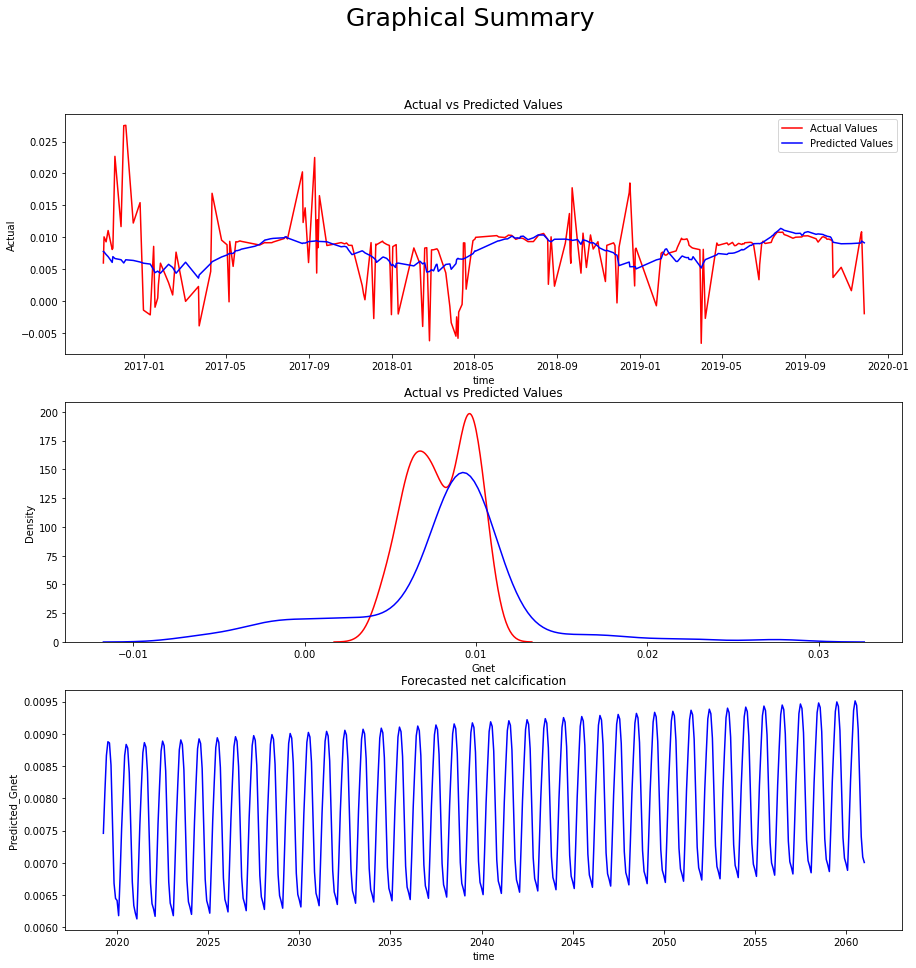

In [20]:
data = Gnet_pred(forecast,Gnet,'davies')


## 7. Visualising the Gnet outcome for each reef

In [21]:
yule = xr.open_dataset('future_Gnet/yule_pred.nc')
yule= yule.to_dataframe()
unnamed = xr.open_dataset('future_Gnet/UnNamed_pred.nc')
unnamed= unnamed.to_dataframe()
davies = xr.open_dataset('future_Gnet/davies_pred.nc')
davies= davies.to_dataframe()
feather = xr.open_dataset('future_Gnet/feather_pred.nc')
feather= feather.to_dataframe()
hardy = xr.open_dataset('future_Gnet/hardy_pred.nc')
hardy= hardy.to_dataframe()
heron = xr.open_dataset('future_Gnet/heron_pred.nc')
heron= heron.to_dataframe()
key = xr.open_dataset('future_Gnet/key_pred.nc')
key= key.to_dataframe()
lizard = xr.open_dataset('future_Gnet/lizard_pred.nc')
lizard= lizard.to_dataframe()
pike = xr.open_dataset('future_Gnet/pike_pred.nc')
pike= pike.to_dataframe()

In [22]:
combined = pd.concat([yule.assign(dataset='yule'), unnamed.assign(dataset='unnamed'),
                      davies.assign(dataset='davies'),feather.assign(dataset='unnamed'),
                     hardy.assign(dataset='hardy'),heron.assign(dataset='heron'),key.assign(dataset='key'),
                     lizard.assign(dataset='lizard'), pike.assign(dataset='pike')])


In [23]:
combined = combined.reset_index()


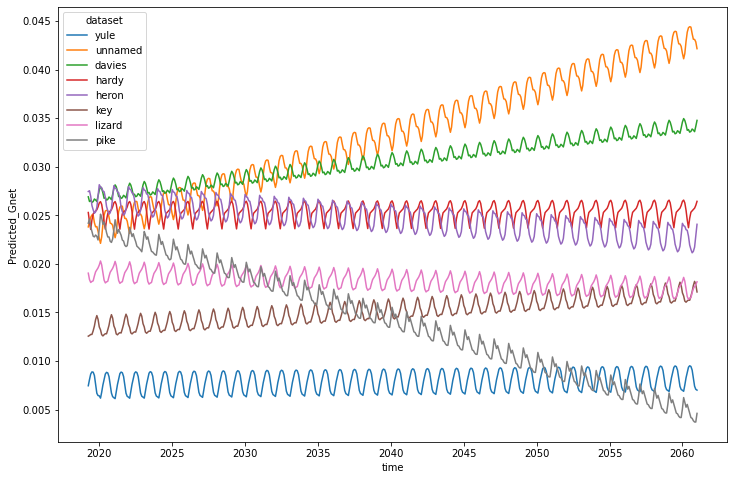

In [24]:
plt.figure(figsize=(12, 8))

sns.lineplot(x='time', y='Predicted_Gnet', data=combined,
                hue='dataset', ci=None)

plt.savefig('Predicted-Gnet.png', dpi=200)
plt.show()